In [1]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/andrea/workspace/BlackLivesMatter/DSI Capstone F19 Group 1-2a85508f6569.json'

In [2]:
import matplotlib.pyplot as plt
from google.cloud import bigquery
import networkx as nx

%load_ext google.cloud.bigquery
plt.style.use('fivethirtyeight')

In [3]:
bigquery_client = bigquery.Client(project='dsi-capstone-f19-group-1')

In [10]:
%%bigquery df_date
select day_of_tweet, count(*) as count_tweets, 
        count(distinct id) as unique_id,
        count(distinct user_id) as unique_user_id,
        sum(cast(user_verified as INT64)) as num_verified
from tweets.all_valid_tweets group by 1;

In [14]:
df_date = df_date.sort_values(by='day_of_tweet')

([<matplotlib.axis.YTick at 0x118d00150>,
 <a list of 7 Text yticklabel objects>)

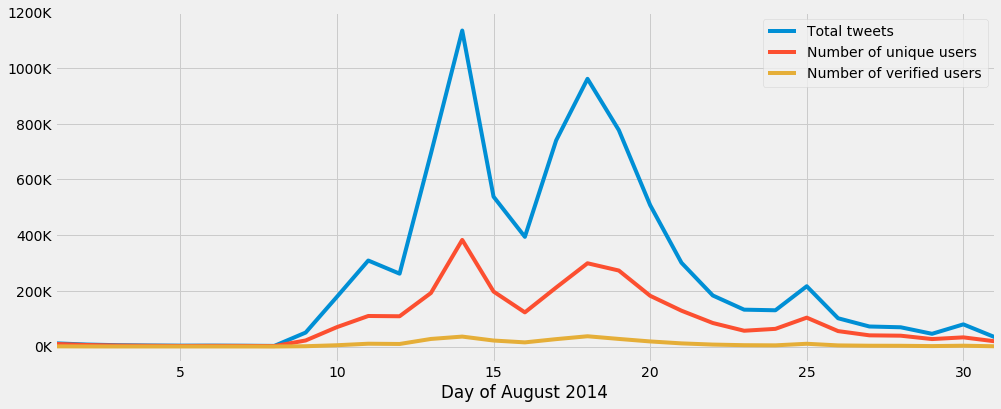

In [18]:
ax = df_date.plot(x='day_of_tweet',
             y='count_tweets',
             kind='line',
             figsize=(15,6),
             label='Total tweets')
df_date.plot(x='day_of_tweet',
            y='unique_user_id',
            kind='line',
            label='Number of unique users',
            ax=ax)
df_date.plot(x='day_of_tweet',
            y='num_verified',
            kind='line',
            label='Number of verified users',
            ax=ax)
plt.xlabel('Day of August 2014')
ylocs, ylabels = plt.yticks()
ylocs = [yloc for yloc in ylocs if yloc>= 0]
ylabels = [str(int(loc/1e3)) + 'K' for loc in ylocs]
plt.yticks(ylocs, ylabels)

xticks = np.arange(1,32,1)
plt.xticks(xticks)

### Network Analysis

In [18]:
def convert_to_list(row):
    list_row = row.strip('][').split(', ')
    if list_row[0] != '':
        return [int(x) for x in list_row]
    else:
        return []
    
def define_network(df):
    df['user_id_mentions'] = df['user_id_mentions'].map(convert_to_list)
    network_dict = df.set_index('user_id').to_dict()['user_id_mentions']
    # network
    G = nx.DiGraph()
    G.add_nodes_from(network_dict.keys())
    for k, v in network_dict.items():
        G.add_edges_from(([(k, t) for t in v]))
        
    N, K = G.order(), G.size()
    avg_deg = float(K) / N
    print("Number of Nodes: ", N)
    print("Number of Edges: ", K)
    print("Average degree: ", avg_deg)
    print("SCC: ", nx.number_strongly_connected_components(G))
    print("WCC: ", nx.number_weakly_connected_components(G))
    print("Average clustering coefficient: ", nx.average_clustering(G))
    return G

def plot_indegree(G):
    in_degrees = G.in_degree() # dictionary node:degree
    in_values = sorted(set(dict(in_degrees).values()))
    in_hist = [list(dict(in_degrees).values()).count(x) for x in in_values]
    plt.figure(figsize=(10,6)) # you need to first do 'import pylab as plt'
    #plt.loglog(in_values, in_hist, '-') # in-degree
    plt.hist(in_values, bins=10)
    plt.xlabel('In degree')
    plt.title('Histogram of In degree in Network')
    plt.show()

def plot_outdegree(G):
    out_degrees = G.out_degree() # dictionary node:degree
    out_values = sorted(set(dict(out_degrees).values()))
    out_hist = [list(dict(out_degrees).values()).count(x) for x in out_values]
    plt.figure(figsize=(10,6)) # you need to first do 'import pylab as plt'
    #plt.loglog(in_values, in_hist, '-') # in-degree
    plt.hist(out_values) #, bins=10)
    plt.xlabel('In degree')
    plt.title('Histogram of Out degree in Network')
    plt.show()
    
def centrality(G):
    G_ud = G.to_undirected()
    # Connected components are sorted in descending order of their size
    g_components = nx.connected_component_subgraphs(G_ud)
    g_mc = list(g_components)[0]
    # Betweenness centrality
    bet_cen = nx.betweenness_centrality(g_mc)
    # Closeness centrality
    clo_cen = nx.closeness_centrality(g_mc)
    # Eigenvector centrality
    eig_cen = nx.eigenvector_centrality(g_mc)
    return bet_cen, clo_cen, eig_cen

In [37]:
%%bigquery df_mentions
select user_id, user_id_mentions
from tweets.all_valid_tweets

In [5]:
%%bigquery df_mentions_rt
select user_id, if(full_text not like 'RT %',  user_id_mentions, '[]') as user_id_mentions
from tweets.all_valid_tweets

In [6]:
df_mentions_rt.head()

,user_id,user_id_mentions
0,367553884,[973267447318016000]
1,272984575,"[15224867, 759251]"
2,18301810,[]
3,34135168,[167956683]
4,1054095900,[]


In [7]:
df_mentions_rt.shape

(7949794, 2)

In [8]:
df_mentions_rt['user_id_mentions'].iloc[0]

'[973267447318016000]'

In [9]:
g = define_network(df_mentions_rt)

Number of Nodes:  1239929
Number of Edges:  130908
Average degree:  0.10557701287735023
SCC:  1239777
WCC:  1124070
Average clustering coefficient:  0.0007622822968885423


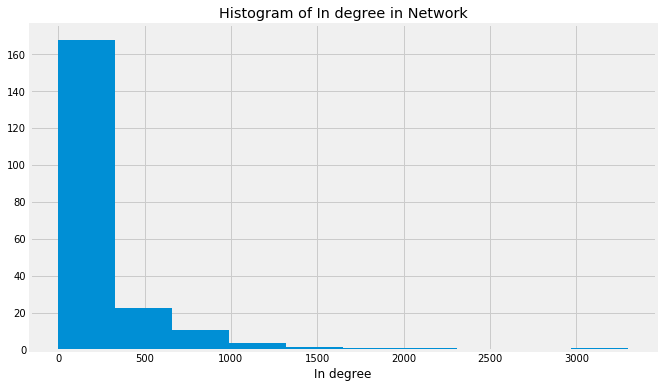

In [10]:
plot_indegree(g)

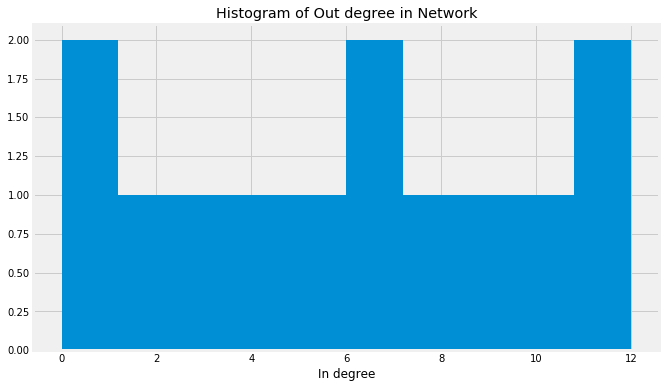

In [19]:
plot_outdegree(g)

In [11]:
in_degrees = g.in_degree()

In [15]:
import operator

max(dict(in_degrees).items(), key=operator.itemgetter(1))[0]

10228272

In [20]:
max(dict(in_degrees).values())

3297